# EYE FOR BLIND

Author : Abhisek Ghosh


Batch  : ML_C27(March 2021 - April 2022)

## 1. Importing libraries and setting up the environment

In [1]:
#Import all the required libraries

import sys
import os
import warnings
import tqdm
import glob
import csv
import re
import time
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from enum import Enum
import tqdm
import pathlib

from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3

import nltk
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from typing import Any
import contractions

from gtts import gTTS
from playsound import playsound
from colorama import Fore

warnings.filterwarnings('ignore')
sns.set_style('dark')


*Checks on drivers*

In [2]:
# Check Tensorflow version

print(f'TF version -> {tf.__version__}')

TF version -> 2.8.0


In [3]:
# Check nvidia drivers

list(os.popen('nvcc -V'))

['nvcc: NVIDIA (R) Cuda compiler driver\n',
 'Copyright (c) 2005-2021 NVIDIA Corporation\n',
 'Built on Thu_Nov_18_09:52:33_Pacific_Standard_Time_2021\n',
 'Cuda compilation tools, release 11.5, V11.5.119\n',
 'Build cuda_11.5.r11.5/compiler.30672275_0\n']

In [4]:
# Check if GPU is being recognised by TF

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Check status of nivdia GPU

list(os.popen('nvidia-smi'))

['Tue Apr 12 19:39:43 2022       \n',
 '+-----------------------------------------------------------------------------+\n',
 '| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |\n',
 '|-------------------------------+----------------------+----------------------+\n',
 '| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |\n',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |\n',
 '|                               |                      |               MIG M. |\n',
 '|===============================+======================+======================|\n',
 '|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |\n',
 '| N/A   43C    P0    16W /  N/A |    313MiB /  4096MiB |      3%      Default |\n',
 '|                               |                      |                  N/A |\n',
 '+-------------------------------+----------------------+----------------------+\n',
 '              

## 2. Declare constants

In [6]:
# Declaring  string contants

START_TOKEN = '<start>'
END_TOKEN = '<end>'
OOV_TOKEN = '<UNK>'

# Declaring numerical constants

IMAGE_SHAPE = (299,299)
BATCH_SIZE_PREPROCESSING = 16
BATCH_SIZE_DATASET = 64
BATCH_SIZE_TRAIN = 64

BUFFER_SIZE = 1000
LR = 0.01

# Decalring enum constants

class CAPTION_RETURN_TYPE(Enum):
    """ Enum constant to define return type of captions from file """
    get_as_list = 0
    get_as_string = 1

# Declaring path constants - <Running in different setup, if any change do here>

IMAGES_DIR = './datasets/flickr8k/Images'
CAPTIONS_PATH = './datasets/flickr8k/captions.txt'

## 3. Data understanding


        1.Import the dataset and read image & captions into two seperate variables

        2.Visualise both the images & text present in the dataset

        3.Create a dataframe which summarizes the image, path & captions as a dataframe

        4.Create a list which contains all the captions & path

        5.Visualise the top 30 occuring words in the captions



In [7]:
#Import the dataset and read the image into a seperate variable

all_imgs = [os.path.abspath(path) for path in pathlib.Path(IMAGES_DIR).rglob('*.jpg')]
print(f"The total images present in the dataset: {len(all_imgs)}")
all_imgs[:5]

The total images present in the dataset: 8091


['g:\\pgd ai ml\\Codes\\Capstone Project\\datasets\\flickr8k\\Images\\1000268201_693b08cb0e.jpg',
 'g:\\pgd ai ml\\Codes\\Capstone Project\\datasets\\flickr8k\\Images\\1001773457_577c3a7d70.jpg',
 'g:\\pgd ai ml\\Codes\\Capstone Project\\datasets\\flickr8k\\Images\\1002674143_1b742ab4b8.jpg',
 'g:\\pgd ai ml\\Codes\\Capstone Project\\datasets\\flickr8k\\Images\\1003163366_44323f5815.jpg',
 'g:\\pgd ai ml\\Codes\\Capstone Project\\datasets\\flickr8k\\Images\\1007129816_e794419615.jpg']

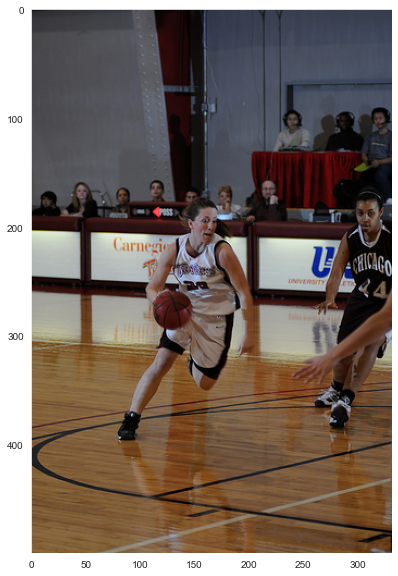

In [8]:
#Visualise both the images & text present in the dataset

plt.figure(figsize=[10,10])
plt.imshow(plt.imread(all_imgs[np.random.randint(len(all_imgs)-1)]))
plt.show()

In [9]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename, return_type: CAPTION_RETURN_TYPE):
    """ Load the captions file

    Args:
        filename (str): Filepath of the document
        return_type (CAPTION_RETURN_TYPE): Enum of return type

    Returns:
        (tuple[list[str], list[list[str]]] | str): List./String of the content
    """
    if return_type == CAPTION_RETURN_TYPE.get_as_list:
        text = csv.reader(open(filename, 'r'), delimiter=',')
        header = next(text)
        text = [row for row in text]
        return header, text

    elif return_type == CAPTION_RETURN_TYPE.get_as_string:
        with open(filename, 'r') as _f:
            doc = _f.read()
        return doc

In [10]:
# Display the captions.txt data first 300 words

doc = load_doc(CAPTIONS_PATH, CAPTION_RETURN_TYPE.get_as_string)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [11]:
def extract_img_details(img_info: list, img_dataset_dir: str) -> tuple:
    """ Method to combine image id, path and captions into a tuple """
    id_lst = []
    path_lst = []
    captions_lst = []
    for info in tqdm.tqdm(img_info):
        _img_name, _captions = (info[0], info[1])
        _id = os.path.splitext(_img_name)[0]
        _paths = img_dataset_dir + '/'+_img_name
        id_lst.append(_id), path_lst.append(
            _paths), captions_lst.append(_captions)
    return zip(id_lst, path_lst, captions_lst)

In [12]:
# Convert the ID, Path and Captions in to a pandas dataframe

header, doc = load_doc(CAPTIONS_PATH, CAPTION_RETURN_TYPE.get_as_list)
df = pd.DataFrame(list(extract_img_details(doc, IMAGES_DIR)),
                  columns=['ID', 'Path', 'Captions'])
df.head(10)

100%|██████████| 40455/40455 [00:00<00:00, 799452.37it/s]


ID                                               Path  \
0  1000268201_693b08cb0e  ./datasets/flickr8k/Images/1000268201_693b08cb...   
1  1000268201_693b08cb0e  ./datasets/flickr8k/Images/1000268201_693b08cb...   
2  1000268201_693b08cb0e  ./datasets/flickr8k/Images/1000268201_693b08cb...   
3  1000268201_693b08cb0e  ./datasets/flickr8k/Images/1000268201_693b08cb...   
4  1000268201_693b08cb0e  ./datasets/flickr8k/Images/1000268201_693b08cb...   
5  1001773457_577c3a7d70  ./datasets/flickr8k/Images/1001773457_577c3a7d...   
6  1001773457_577c3a7d70  ./datasets/flickr8k/Images/1001773457_577c3a7d...   
7  1001773457_577c3a7d70  ./datasets/flickr8k/Images/1001773457_577c3a7d...   
8  1001773457_577c3a7d70  ./datasets/flickr8k/Images/1001773457_577c3a7d...   
9  1001773457_577c3a7d70  ./datasets/flickr8k/Images/1001773457_577c3a7d...   

                                            Captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

### 3.1. Pre-Processing the captions





    • Creating the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
      This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

    • Replacing all other words with the unknown token "<UNK>" .

    • Creating word-to-index and index-to-word mappings.

    • Pading all sequences to be the same length as the longest one.

In [13]:
class text_pre_processing():
    """ Class to handle the text cleaning, remove all the unnecessary elements """

    def __init__(self):
        self._stop_words = stopwords.words('english')
        self._contractions_ref = contractions
        self._txt = ''
        self._tokens = Any

    def get_lowercase_text(self):
        """ Method lowers the case """
        self._txt = self._txt.lower()
        #return self._txt

    def remove_text_in_brackets(self):
        """ Method remove text in the square brackets """
        #_bracket_pattern = "[\(\[].*?[\)\]]"
        _bracket_pattern = r"[[].*?[]]"
        re.compile(_bracket_pattern)
        self._txt = re.sub(_bracket_pattern, '', self._txt)
        #return self._txt

    def remove_punctuations(self):
        """" Method remove punctuations """
        _punc_pattern = r'[^\w\s]'
        re.compile(_punc_pattern)
        self._txt = re.sub(_punc_pattern, '', self._txt)
        #return self._txt

    def remove_numbers(self):
        """" Method remove numbers """
        _num_pattern = r'\d+'
        re.compile(_num_pattern)
        self._txt = re.sub(_num_pattern, '', self._txt)

    def remove_custom_pattern(self):
        """" Method remove custom pattern in the text data  """
        _custom_pattern = r'\n'

        re.compile(_custom_pattern)
        self._txt = re.subn(_custom_pattern, '', self._txt,
                            flags=re.IGNORECASE)[0]

    def remove_duplicate_words(self):
        """ Method to delete duplicate words """
        self._txt = ' '.join(dict.fromkeys(self._txt.split()))

    def handle_contractions(self):
        """ Method transforms the contraction in the text data """
        self._txt = ' '.join([self._contractions_ref.fix(word)
                             for word in self._txt.split()])

    def wrapper_text_pre_processing(self, text: str):
        """ Wrapper method to streamline the text pre-processing """
        self._txt = text
        self.get_lowercase_text()
        self.remove_text_in_brackets()
        self.handle_contractions()
        self.remove_punctuations()
        self.remove_numbers()
        self.remove_custom_pattern()  
        return self._txt.strip()

    def remove_stopwords(self, text):
        return ' '.join([word for word in text.split() if word not in  self._stop_words])

    def create_vocabulary_count(self, lst_text):
        _text = ' '.join(lst_text)
        _vocab = _text.split()
        _vocab_count = Counter(_vocab)
        return _vocab_count
        

In [14]:
# Initialising the text pre-processing class

txt_pre_proc = text_pre_processing()

In [15]:
#Create a list which contains all the captions

annotations = [txt_pre_proc.wrapper_text_pre_processing(caption) for caption in df[['Captions']].values.reshape(-1).tolist()]  # write your code here

print(f"Total captions present in the dataset: {len(annotations)}")
print(f"Total images present in the dataset: {len(all_imgs)}")


Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [16]:
# Displaying first 10 captions

annotations[:10]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a spotted dog are fighting',
 'a black dog and a tricolored dog playing with each other on the road',
 'a black dog and a white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [17]:
#Create the vocabulary & the counter for the captions

val_count = txt_pre_proc.create_vocabulary_count(annotations)
val_count


Counter({'a': 62986,
         'child': 1545,
         'in': 18974,
         'pink': 735,
         'dress': 348,
         'is': 9346,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6714,
         'stairs': 109,
         'an': 2432,
         'entry': 1,
         'way': 50,
         'girl': 3328,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1768,
         'playhouse': 6,
         'the': 18419,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3832,
         'dog': 8136,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tricolored': 14,
         'playing': 2008,
         'with': 7765,
         'each': 430,
         'other': 773,
         'on': 10743,
         'road': 388,
         'white': 3940,
         'brown': 2563,
         'spots': 29,
         'staring': 57,
         'at': 2914,
         'street

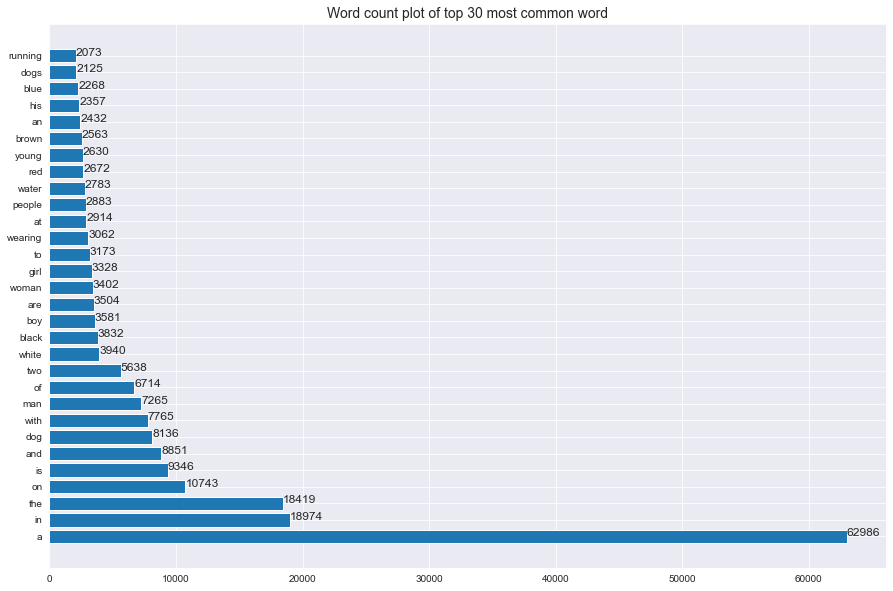

In [18]:
plt.rcParams["figure.figsize"] = (15, 10)
sns.set_style('darkgrid')


most_common_words_df = pd.DataFrame(
    val_count.most_common(30), columns=['words', 'counts'])
plt.barh(most_common_words_df['words'], most_common_words_df['counts'])
for index, val in enumerate(most_common_words_df['counts'].values.tolist()):
    plt.text(val, index, str(val), fontsize=12)


plt.title('Word count plot of top 30 most common word', fontsize = 14)
plt.show()


In [19]:
# Displaying first 10 captions after removing stopwords

annotations_no_stopwords = [txt_pre_proc.remove_stopwords(line) for line in annotations]
annotations_no_stopwords[:10]

['child pink dress climbing set stairs entry way',
 'girl going wooden building',
 'little girl climbing wooden playhouse',
 'little girl climbing stairs playhouse',
 'little girl pink dress going wooden cabin',
 'black dog spotted dog fighting',
 'black dog tricolored dog playing road',
 'black dog white dog brown spots staring street',
 'two dogs different breeds looking road',
 'two dogs pavement moving toward']

In [20]:
# Adding the <start> & <end> token to all those captions as well

annotations = [ f'{START_TOKEN} {caption} {END_TOKEN}' for caption in annotations]
annotations[:5]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>']


Caption -> <start> a group of people mill around while a man in a fish costume descends a staircase <end> 
Image ↲


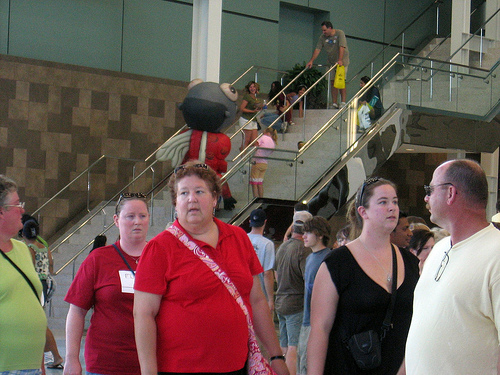

In [21]:
# Displaying a random picture and its corresponding caption 

rand_idx = np.random.randint(len(annotations)-1)
print(f'\nCaption -> {annotations[rand_idx]}','\nImage ↲' )
Image.open(df[['Path']].values.reshape(-1).tolist()[rand_idx])


In [22]:
# Creating the tokenizer

tokenizer = Tokenizer(num_words=5000,
                      filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                      lower=True,
                      char_level=False,
                      oov_token='UNK')

# Fitting the tokenizer on caption data

tokenizer.fit_on_texts(annotations)


In [23]:
# Creating word-to-index and index-to-word mappings.


print(f'Word to index mapping ↲\n{list(tokenizer.word_index.items())[:50]}')
print(f'\n\nIndex to word mapping ↲\n{list(tokenizer.index_word.items())[:50]}')

Word to index mapping ↲
[('UNK', 1), ('a', 2), ('<start>', 3), ('<end>', 4), ('in', 5), ('the', 6), ('on', 7), ('is', 8), ('and', 9), ('dog', 10), ('with', 11), ('man', 12), ('of', 13), ('two', 14), ('white', 15), ('black', 16), ('boy', 17), ('are', 18), ('woman', 19), ('girl', 20), ('to', 21), ('wearing', 22), ('at', 23), ('people', 24), ('water', 25), ('red', 26), ('young', 27), ('brown', 28), ('an', 29), ('his', 30), ('blue', 31), ('dogs', 32), ('running', 33), ('through', 34), ('playing', 35), ('while', 36), ('down', 37), ('shirt', 38), ('standing', 39), ('ball', 40), ('little', 41), ('grass', 42), ('child', 43), ('person', 44), ('snow', 45), ('jumping', 46), ('over', 47), ('front', 48), ('three', 49), ('sitting', 50)]


Index to word mapping ↲
[(1, 'UNK'), (2, 'a'), (3, '<start>'), (4, '<end>'), (5, 'in'), (6, 'the'), (7, 'on'), (8, 'is'), (9, 'and'), (10, 'dog'), (11, 'with'), (12, 'man'), (13, 'of'), (14, 'two'), (15, 'white'), (16, 'black'), (17, 'boy'), (18, 'are'), (19, 'woma

In [24]:
# Creating a word count of your tokenizer 

word_count_dict = {k: v for k, v in sorted(tokenizer.word_counts.items(), reverse=True, key=lambda item: item[1])}
word_count_dict


{'a': 62986,
 '<start>': 40455,
 '<end>': 40455,
 'in': 18974,
 'the': 18419,
 'on': 10743,
 'is': 9346,
 'and': 8851,
 'dog': 8136,
 'with': 7765,
 'man': 7265,
 'of': 6714,
 'two': 5638,
 'white': 3940,
 'black': 3832,
 'boy': 3581,
 'are': 3504,
 'woman': 3402,
 'girl': 3328,
 'to': 3173,
 'wearing': 3062,
 'at': 2914,
 'people': 2883,
 'water': 2783,
 'red': 2672,
 'young': 2630,
 'brown': 2563,
 'an': 2432,
 'his': 2357,
 'blue': 2268,
 'dogs': 2125,
 'running': 2073,
 'through': 2032,
 'playing': 2008,
 'while': 1968,
 'down': 1825,
 'shirt': 1806,
 'standing': 1787,
 'ball': 1779,
 'little': 1768,
 'grass': 1622,
 'child': 1545,
 'person': 1542,
 'snow': 1492,
 'jumping': 1472,
 'over': 1414,
 'front': 1386,
 'three': 1381,
 'sitting': 1368,
 'holding': 1324,
 'field': 1280,
 'small': 1278,
 'up': 1260,
 'by': 1248,
 'large': 1235,
 'green': 1225,
 'group': 1218,
 'one': 1217,
 'yellow': 1213,
 'her': 1178,
 'walking': 1165,
 'children': 1156,
 'men': 1121,
 'into': 1074,
 'air'

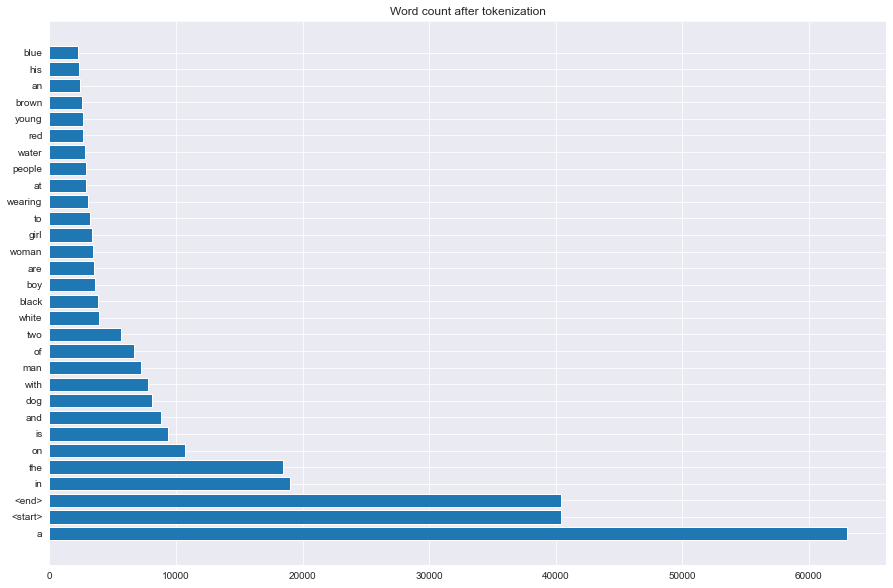

In [25]:
# Visualizing the Top 30 occuring words after text processing

plt.rcParams["figure.figsize"] = (15, 10)
plt.barh(*zip(*list(word_count_dict.items())[:30]))
plt.title('Word count after tokenization')
plt.show()


In [26]:
# Transforming - class allows to vectorize a text corpus

sequences = tokenizer.texts_to_sequences(annotations)

print(f'Top five rows of sequence(Without padding) ↲')
for seq in sequences[:5]:
    print(seq)

Top five rows of sequence(Without padding) ↲
[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 695, 4]
[3, 2, 20, 315, 65, 2, 195, 118, 4]
[3, 2, 41, 20, 120, 65, 2, 195, 2427, 4]
[3, 2, 41, 20, 120, 6, 393, 21, 61, 2427, 4]
[3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2990, 4]


In [27]:
max_length = max([len(sent_lst) for sent_lst in sequences])
print(
    f'\nMax length of row in whole sequence -> {max_length}')


Max length of row in whole sequence -> 37


*So the maximum length of sequence is 37, hence we'll use that for padding*

In [28]:
# Padding each vector to the max_length of the captions  store it to a vairable

cap_vector = sequence.pad_sequences(sequences,
                                    maxlen = max_length,
                                    dtype='int32',
                                    padding='post',
                                    truncating='post',
                                    value=0)  

print(f"The shape of Caption vector is : {cap_vector.shape}")


The shape of Caption vector is : (40455, 37)


In [29]:
print(f'Top five rows of sequence(With padding) ↲')
idx = 0
for vector in cap_vector[:5].reshape(5, -1).tolist():
    print(f'Vector[{idx}] -> {vector}, Length = {len(vector)}\n')
    idx+=1

Top five rows of sequence(With padding) ↲
Vector[0] -> [3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 695, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Length = 37

Vector[1] -> [3, 2, 20, 315, 65, 2, 195, 118, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Length = 37

Vector[2] -> [3, 2, 41, 20, 120, 65, 2, 195, 2427, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Length = 37

Vector[3] -> [3, 2, 41, 20, 120, 6, 393, 21, 61, 2427, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Length = 37

Vector[4] -> [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2990, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Length = 37



## 4. Pre-processing the images

    1.Resizing them into the shape of (299, 299)

    3.Normalizing the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [30]:
# Preprocesses a tensor or Numpy array encoding a batch of images.
# Preprocessed numpy.array or a tf.Tensor with type float32.
# The inputs pixel values are scaled between -1 and 1, sample-wise.


def load_image(image_path):
    """Loads image and applies preprocessing.

    Args:
        image_path (str): path of the image

    Returns:
        tuple: Tuple of pre-processed image and its path
    """

    # Read the file
    src = tf.io.read_file(image_path, name=None)

    # Decode a JPEG-encoded image to a uint8 tensor.
    src = tf.io.decode_jpeg(src, channels=3)

    # Resizing the image to 299x299
    src = tf.keras.layers.Resizing(height= IMAGE_SHAPE[0], width=IMAGE_SHAPE[1])(src)

    # Normalizing the image into [-1, 1] range
    src = tf.keras.applications.inception_v3.preprocess_input(src)
    return src, image_path


*We need to test the function on a small sample so as to see if its working fine or not*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


g:\pgd ai ml\Codes\Capstone Project\datasets\flickr8k\Images\1000268201_693b08cb0e.jpg (299, 299, 3) 1.0 -1.0
g:\pgd ai ml\Codes\Capstone Project\datasets\flickr8k\Images\1001773457_577c3a7d70.jpg (299, 299, 3) 1.0 -0.98021233
g:\pgd ai ml\Codes\Capstone Project\datasets\flickr8k\Images\1002674143_1b742ab4b8.jpg (299, 299, 3) 1.0 -1.0
g:\pgd ai ml\Codes\Capstone Project\datasets\flickr8k\Images\1003163366_44323f5815.jpg (299, 299, 3) 1.0 -1.0
g:\pgd ai ml\Codes\Capstone Project\datasets\flickr8k\Images\1007129816_e794419615.jpg (299, 299, 3) 1.0 -1.0


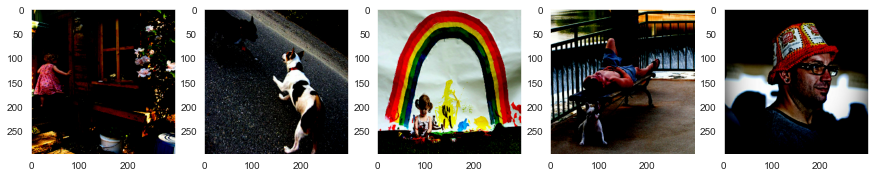

<Figure size 1440x1800 with 0 Axes>

In [31]:
# Testing the load image function on sample size of 5


sns.set_style('dark')

figure, axes = plt.subplots(1, 5)
idx = 0
plt.figure(figsize=(20,25))
for ax in axes:
    img,  _path = load_image(all_imgs[idx])
    idx += 1
    print(_path, img.shape, img.numpy().max(), img.numpy().min())
    ax.imshow(img)

plt.tight_layout()
plt.show()


In [32]:
# Getting all image path in  a list from the dataframe

all_img_paths = df[['Path']].values.reshape(-1).tolist()
all_img_paths[:5]

['./datasets/flickr8k/Images/1000268201_693b08cb0e.jpg',
 './datasets/flickr8k/Images/1000268201_693b08cb0e.jpg',
 './datasets/flickr8k/Images/1000268201_693b08cb0e.jpg',
 './datasets/flickr8k/Images/1000268201_693b08cb0e.jpg',
 './datasets/flickr8k/Images/1000268201_693b08cb0e.jpg']

In [33]:
def create_img_dataset(img_path_lst: list, drop_rem: bool):
    """ Create a dataset of preprocessed images and their respective paths wrt to batch size specified """

    # Creating a slice of list of all the images
    img_paths = tf.data.Dataset.from_tensor_slices(sorted(set(img_path_lst)))

    # Mapping the pre-processing pipeline on top of the slice of data
    img_path_dataset = img_paths.map(
        load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Load a batch = batch size and apply the map function which in turn calls the load image function
    img_path_dataset = img_path_dataset.batch(
        BATCH_SIZE_PREPROCESSING, drop_remainder=False)

    return img_path_dataset

### 4.1 Load the pretrained Imagenet weights of Inception net V3

    1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

    2.The shape of the output of this layer is 8x8x2048. 

    3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [34]:
def get_inception_model():

    # Instantiates the Inception V3 architecture
    inception_model = tf.keras.applications.InceptionV3(include_top=False,
                                                        weights='imagenet',)

    # write code here to get the input of the image_model
    new_input = inception_model.input

    # write code here to get the output of the image_model
    hidden_layer = inception_model.layers[-1].output

    # build the final model using both input & output layer
    image_features = tf.keras.Model(inputs=new_input,
                                    outputs=hidden_layer,
                                    name='inception_v3')
    return image_features

In [35]:
image_features_extract_model = get_inception_model()

In [103]:
# Print out the model summary

image_features_extract_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

In [36]:
# check whether keras is set to NCHW or NHWC

tf.keras.backend.image_data_format()

'channels_last'

### 4.2 Dataset creation

*The numpy method is chosen because keeping the dictionary in the RAM was computational expensive*

Also, because of saving feature of images as numpy arrray pickle the data might be populating in the storage, its a good idea to remove them.

In [36]:
count = 0
for n_path in list(pathlib.Path(IMAGES_DIR).rglob('*.npy')):
    if os.path.exists(n_path.absolute()):
        os.remove(n_path)
        count += 1

print(f'Files removed count {count}')

Files removed count 8091


In [37]:
# extract features from each image in the dataset
img_path_dataset = create_img_dataset(img_path_lst=all_img_paths,
                                      drop_rem=False)

for image, image_path in tqdm.tqdm(img_path_dataset, desc='Getting the image features and storing them as np array'):

    # List of length = batch size, having image path as a string
    image_path = ([path.decode() for path in image_path.numpy().tolist()])

    feature_map_batch = image_features_extract_model(image)

    # Flatenning the feature map -> tf.reshape(tensor, shape, name=None)
    feature_map_batch_flattened = tf.reshape(feature_map_batch,
                                             (feature_map_batch.shape[0], -1,
                                              feature_map_batch.shape[3]))

    # Updating the image feaure dictionary with the numpy array having the feature
    for batch_features, path in zip(feature_map_batch_flattened, image_path):

        np.save(path, batch_features.numpy())


Getting the image features and storing them as np array: 100%|██████████| 506/506 [01:02<00:00,  8.11it/s]


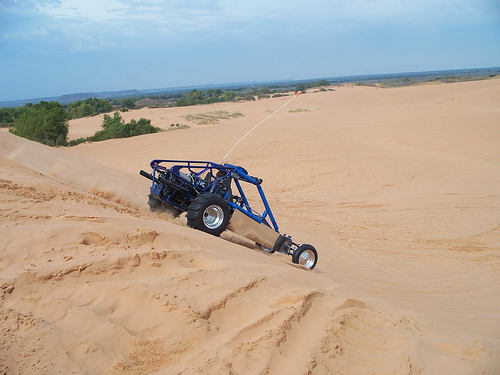

In [38]:
# Choosing a random image and applying the displaying its equivalent numpy array 

rand_img_path = all_img_paths[np.random.randint(len(all_img_paths)-1)]
Image.open(rand_img_path)

In [39]:
# Numpy array of the random image

rand_img_array = np.load(rand_img_path+'.npy')
rand_img_array

array([[0.        , 0.        , 0.        , ..., 0.44960293, 0.        ,
        0.5354679 ],
       [0.        , 0.        , 0.        , ..., 0.17325073, 0.        ,
        0.57514644],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07594632,
        0.37736633],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.4090061 ],
       [0.        , 0.        , 0.00839775, ..., 0.        , 0.        ,
        0.94596386],
       [0.34880593, 0.        , 0.8705964 , ..., 0.        , 0.12258369,
        0.7065888 ]], dtype=float32)

In [40]:
print(f'Shape of one image vector -> {rand_img_array.shape}')

Shape of one image vector -> (64, 2048)


### 4.3 Dataset loading

    1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

    2.Create a function which maps the image path to their feature. 

    3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

    2.Make sure you have done Shuffle and batch while building the dataset

    3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

    4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [41]:
# Splitting the dataset wrt train and test

path_train, path_test, cap_train, cap_test = train_test_split(
    all_img_paths, cap_vector, test_size=0.2, random_state=42)  

In [42]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [43]:
def map_func(image_path, caption):
    """ his function will take the image_path & caption and return it's feature & respective caption. """
    img_tensor = np.load(image_path.decode('utf-8')+'.npy')
    return img_tensor, caption

In [44]:
def gen_dataset(img_path, cap):
    """ Dataset generator function enabling shuffling and parallel CPU core execution """

    # Load up the sliced image path and respective captions
    dataset = tf.data.Dataset.from_tensor_slices((img_path, cap))

    # Maps on top the sliced image and capions data
    # and apply the map_func by using auto-tuning of CPU cores
    dataset = dataset.map(lambda path, caption: tf.numpy_function(map_func, [path, caption], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle the data of size equal to batch size and with a prefetch
    # buffer memory of size 1000 data point using the auto-tuning of CPU cores.
    dataset = (dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True)).batch(
        batch_size=BATCH_SIZE_DATASET, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

    return dataset

In [45]:
# Created a tf dataset for training
train_dataset = gen_dataset(path_train, cap_train)

# Created a tf dataset for testing
test_dataset = gen_dataset(path_test, cap_test)

In [46]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 37)


## 5. Model Building

    1.Setting the parameters

    2.Building the Encoder, Attention model & Decoder

In [47]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE_TRAIN
test_num_steps =len(path_test) // BATCH_SIZE_TRAIN
features_shape = 2048
attention_features_shape = 64

### 5.1 Encoder

In [48]:
class Encoder(Model):
    """ Encoder class to encode the image features to vector and feed to the attenntion model"""

    def __init__(self, embed_dim):

        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(units=embed_dim)

    def call(self, x):

        # extract the features from the image shape: (batch, 8*8, embed_dim)
        x = self.dense(x)
        x = tf.keras.activations.relu(x,
                                             alpha=0.01,
                                             max_value=None,
                                             threshold=0)

        return x

In [49]:
encoder=Encoder(embed_dim=embedding_dim)

### 5.2 Attention model

In [50]:
class Attention_model(Model):
    """ Model to generate the context vector by using feature map and hidden state of decoder """

    def __init__(self, units):
        self.units = units
        super(Attention_model, self).__init__()
        # Dense layer to take inputs of encoder
        self.W1 = tf.keras.layers.Dense(self.units)

        # Dense layer to take hidden inputs of decoder
        self.W2 = tf.keras.layers.Dense(self.units)

        # Dense layer having one neuron to hold the score of a context vector
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # build your score funciton to shape: (batch_size, 8*8, units)
        attention_hidden_layer = tf.keras.activations.tanh(self.W1(features) +
                                                           self.W2(hidden_with_time_axis))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(score, axis=1)

        # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### 5.3 Decoder

In [51]:
class Decoder(Model):
    """ Model to generate the log output of word embeddings by receiving concatenated input from attention model and embedding layers. """

    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # iniitalise your Attention model with units
        self.attention_block = Attention_model(self.units)

        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)

        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        self.d1 = tf.keras.layers.Dense(self.units)

        self.d2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        # create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention_block(
            features, hidden)

        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)

        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)

        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)

        output = self.d1(output)

        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [52]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [53]:
features = encoder(sample_img_batch)

hidden = decoder.reset_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims(
    [tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights = decoder(
    dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(
    features.shape))  # (batch, 8*8, embed_dim)
print('Predictions shape from Decoder: {}'.format(
    predictions.shape))  # (batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(
    attention_weights.shape))  # (batch, 8*8, 1)

Feature shape from Encoder: (64, 64, 256)
Predictions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## 6. Model training & optimization

    1.Set the optimizer & loss object

    2.Create your checkpoint path

    3.Create your training & testing step functions

    4.Create your loss function for the test dataset

*Since decreasing the learning rate as we do training is always a good practice so we use a learning rate scheduler which decreases LR exponentially with respect to a decay rate.*

In [54]:
# defining the optimizer
update_epochs = 4
num_samples_of_whole_dataset = len(path_train)

# Decrease the learning rate after 3 epochs
decay_steps = (update_epochs*num_samples_of_whole_dataset)/BATCH_SIZE_TRAIN
print(math.ceil(decay_steps))

learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=math.ceil(decay_steps),
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

# define the loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE)


2023


In [55]:
def loss_function(real, pred):
    """ Custom loss function so as to take care of loss array and mask the padded part from getting into the loss calculation """

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [56]:
# generate timestamp

timestamp = time.strftime('%H_%M_%S_%d_%m_%Y')
checkpoint_dir = f'./chekpoints/checkpoint_{timestamp}'
os.makedirs(checkpoint_dir)

In [57]:
checkpoint_path = checkpoint_dir + f'/{os.path.basename(checkpoint_dir)}'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [58]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [59]:
@tf.function  # enables graph execution mode
def train_step(img_tensor, target): #, trigger):
    #factor = 0.2
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        # write your code here to do the training steps
        encoder_features = encoder(img_tensor)
        for r in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(
                dec_input, encoder_features, hidden)
            loss += loss_function(target[:, r], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, r], 1)

    avg_loss = (loss/int(target.shape[1]))
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    dy_dx = tape.gradient(loss, trainable_vars)
    """if trigger:
        optimizer.learning_rate = optimizer.learning_rate * factor"""
    optimizer.apply_gradients(zip(dy_dx, trainable_vars))

    return loss, avg_loss

While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.


    • The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.

    • Stop predicting when the model predicts the end token.

    • And store the attention weights for every time step.

In [60]:
@tf.function  # enables graph execution mode
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims(
        [tokenizer.word_index[START_TOKEN]] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
            loss = loss + loss_function(target[:, r], predictions)
            # No teacher forcing
            dec_input = tf.expand_dims(target[:, r], 1)
    avg_loss = (loss / int(target.shape[1]))  # avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))
    return loss, avg_loss

In [61]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss = total_loss/test_num_steps

    return avg_test_loss

In [62]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20


best_test_loss = 100
for epoch in tqdm.tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss = total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print(Fore.YELLOW+'For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(
        epoch+1, avg_train_loss, test_loss))
    print(Fore.YELLOW+'Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

    if test_loss < best_test_loss:
        print(Fore.YELLOW+'Test loss has been reduced from %.3f to %.3f' %
              (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

    print(Fore.BLUE+'*'*100)

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.309, & test loss is 1.164
Time taken for 1 epoch 202.874924659729 sec

Test loss has been reduced from 100.000 to 1.164


  5%|▌         | 1/20 [03:23<1:04:18, 203.10s/it]

****************************************************************************************************
For epoch: 2, the train loss is 1.098, & test loss is 1.078
Time taken for 1 epoch 155.54266452789307 sec

Test loss has been reduced from 1.164 to 1.078


 10%|█         | 2/20 [05:58<52:34, 175.26s/it]  

****************************************************************************************************
For epoch: 3, the train loss is 1.043, & test loss is 1.036
Time taken for 1 epoch 150.4828324317932 sec

Test loss has been reduced from 1.078 to 1.036


 15%|█▌        | 3/20 [08:29<46:28, 164.04s/it]

****************************************************************************************************
For epoch: 4, the train loss is 1.009, & test loss is 1.006
Time taken for 1 epoch 150.23900532722473 sec

Test loss has been reduced from 1.036 to 1.006


 20%|██        | 4/20 [11:00<42:18, 158.68s/it]

****************************************************************************************************
For epoch: 5, the train loss is 0.980, & test loss is 0.979
Time taken for 1 epoch 150.22307538986206 sec

Test loss has been reduced from 1.006 to 0.979


 25%|██▌       | 5/20 [13:30<38:55, 155.71s/it]

****************************************************************************************************
For epoch: 6, the train loss is 0.958, & test loss is 0.959
Time taken for 1 epoch 150.131676197052 sec

Test loss has been reduced from 0.979 to 0.959


 30%|███       | 6/20 [16:00<35:54, 153.89s/it]

****************************************************************************************************
For epoch: 7, the train loss is 0.936, & test loss is 0.935
Time taken for 1 epoch 150.11868834495544 sec

Test loss has been reduced from 0.959 to 0.935


 35%|███▌      | 7/20 [18:31<33:05, 152.75s/it]

****************************************************************************************************
For epoch: 8, the train loss is 0.918, & test loss is 0.918
Time taken for 1 epoch 150.07789206504822 sec

Test loss has been reduced from 0.935 to 0.918


 40%|████      | 8/20 [21:01<30:23, 151.97s/it]

****************************************************************************************************
For epoch: 9, the train loss is 0.899, & test loss is 0.900
Time taken for 1 epoch 150.03611707687378 sec

Test loss has been reduced from 0.918 to 0.900


 45%|████▌     | 9/20 [23:31<27:45, 151.44s/it]

****************************************************************************************************
For epoch: 10, the train loss is 0.883, & test loss is 0.882
Time taken for 1 epoch 150.33215045928955 sec

Test loss has been reduced from 0.900 to 0.882


 50%|█████     | 10/20 [26:02<25:11, 151.16s/it]

****************************************************************************************************
For epoch: 11, the train loss is 0.865, & test loss is 0.865
Time taken for 1 epoch 150.09742069244385 sec

Test loss has been reduced from 0.882 to 0.865


 55%|█████▌    | 11/20 [28:32<22:38, 150.91s/it]

****************************************************************************************************
For epoch: 12, the train loss is 0.851, & test loss is 0.848
Time taken for 1 epoch 150.06712770462036 sec

Test loss has been reduced from 0.865 to 0.848


 60%|██████    | 12/20 [31:02<20:05, 150.72s/it]

****************************************************************************************************
For epoch: 13, the train loss is 0.836, & test loss is 0.836
Time taken for 1 epoch 150.1505470275879 sec

Test loss has been reduced from 0.848 to 0.836


 65%|██████▌   | 13/20 [33:33<17:34, 150.62s/it]

****************************************************************************************************


 70%|███████   | 14/20 [36:03<15:02, 150.49s/it]

For epoch: 14, the train loss is 0.822, & test loss is 0.837
Time taken for 1 epoch 150.20618104934692 sec

****************************************************************************************************
For epoch: 15, the train loss is 0.810, & test loss is 0.808
Time taken for 1 epoch 150.23060750961304 sec

Test loss has been reduced from 0.836 to 0.808


 75%|███████▌  | 15/20 [38:34<12:32, 150.48s/it]

****************************************************************************************************
For epoch: 16, the train loss is 0.795, & test loss is 0.794
Time taken for 1 epoch 150.08211135864258 sec

Test loss has been reduced from 0.808 to 0.794


 80%|████████  | 16/20 [41:04<10:01, 150.43s/it]

****************************************************************************************************
For epoch: 17, the train loss is 0.782, & test loss is 0.782
Time taken for 1 epoch 150.14858388900757 sec

Test loss has been reduced from 0.794 to 0.782


 85%|████████▌ | 17/20 [43:34<07:31, 150.42s/it]

****************************************************************************************************
For epoch: 18, the train loss is 0.771, & test loss is 0.770
Time taken for 1 epoch 151.7833330631256 sec

Test loss has been reduced from 0.782 to 0.770


 90%|█████████ | 18/20 [46:06<05:01, 150.89s/it]

****************************************************************************************************
For epoch: 19, the train loss is 0.759, & test loss is 0.760
Time taken for 1 epoch 112.88774847984314 sec

Test loss has been reduced from 0.770 to 0.760


 95%|█████████▌| 19/20 [47:59<02:19, 139.55s/it]

****************************************************************************************************
For epoch: 20, the train loss is 0.749, & test loss is 0.748
Time taken for 1 epoch 95.24343013763428 sec

Test loss has been reduced from 0.760 to 0.748


100%|██████████| 20/20 [49:35<00:00, 148.76s/it]

****************************************************************************************************


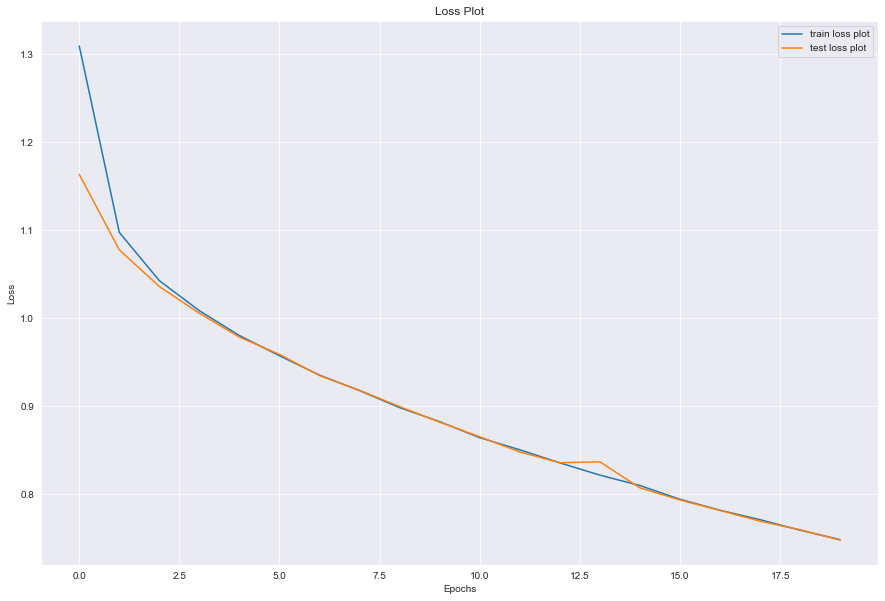

In [73]:
sns.set_style('darkgrid')
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.legend(['train loss plot', 'test loss plot'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')

plt.show()

## 7. Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### 7.1 Greedy Search

In [74]:
def evaluate(image):
    """ Function to evaluate the model performance """
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0)

    # Extract features using our feature extraction model
    img_tensor_val = image_features_extract_model(temp_input)

    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val.numpy())

    dec_input = tf.expand_dims([tokenizer.word_index[START_TOKEN]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden)  # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        # extract the predicted id(embedded value) which carries the max value
        predicted_idx = tf.random.categorical(predictions, 1)[0][0].numpy()

        # map the id to the word from tokenizer and append the value to the result list
        predicted_word = tf.compat.as_text(
            tokenizer.index_word[predicted_idx])  # .numpy())
        result.append(predicted_word)

        if tokenizer.index_word[predicted_idx] == END_TOKEN:
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_idx], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

In [75]:
def plot_attmap(caption, weights, image):
    """ Plot the attention weights on the image """

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8, 8))
        weights_img = np.array(Image.fromarray(
            weights_img).resize((224, 224), Image.LANCZOS))
        if len_cap % 2 != 0:
            len_cap += 1
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img = ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat',
                  alpha=0.6, extent=img.get_extent())
        ax.axis('off')

    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [76]:

def filt_text(text):
    filt=[START_TOKEN, 'UNK',END_TOKEN] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [77]:
def test_model():
    sns.set_style('dark')
    rid = np.random.randint(0, len(path_test))
    test_image = path_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i]
                            for i in cap_test[rid] if i not in [0]])

    result, attention_plot, pred_test = evaluate(test_image)

    real_caption = filt_text(real_caption)
    length_of_real_caption = len(real_caption.split())

    pred_caption = ' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn

    candidate = pred_caption.split()
    pred_caption = ' '.join(candidate)
    pred_caption = filt_text(pred_caption)

    score = sentence_bleu(reference, candidate,  weights=(0.5, 0.5, 0, 0))

    text_v = f'Original caption is {real_caption}, and predicted caption is {pred_caption}'
    myobj = gTTS(text=text_v, lang='en', slow=False)
    mp3_fp = os.path.abspath(f'./Voices/text_to_voice_{timestamp}.mp3')
    myobj.save(mp3_fp)

    print(f"BLEU score: {score*100}")

    print(f'Real Caption -> {real_caption}')
    print(f'Prediction Caption -> {pred_caption}')
    plot_attmap(result, attention_plot, test_image)

    plt.imshow(cv2.cvtColor(cv2.imread(test_image), cv2.COLOR_BGR2RGB))

    playsound(mp3_fp, block=True)

### 7.2 Test on the sample images

BLEU score: 1.3468401129116942e-153
Real Caption -> a man wearing a red hat has a potato chip in his mouth
Prediction Caption -> the man eats the bases


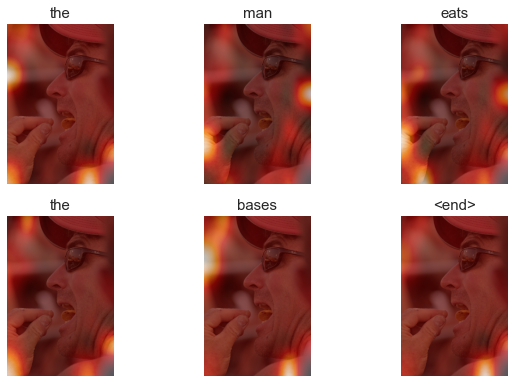

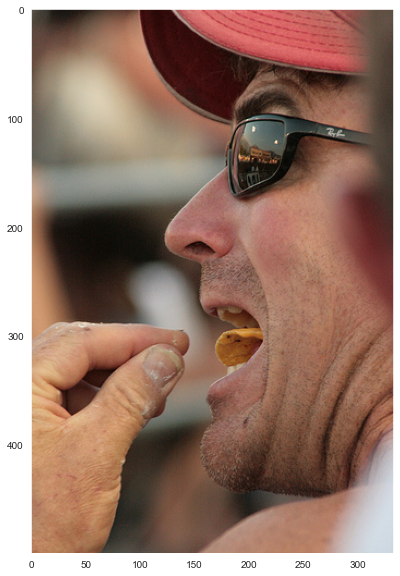

In [78]:
# Test 1

test_model()

BLEU score: 15.432215303129293
Real Caption -> five people are standing in front of an industrial style building posing for a photograph
Prediction Caption -> three people are looking at a picture of a woman in a glass courtyard


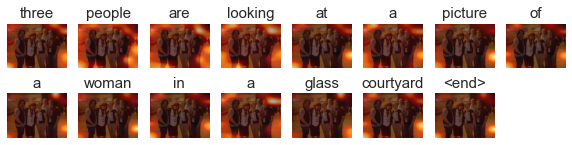

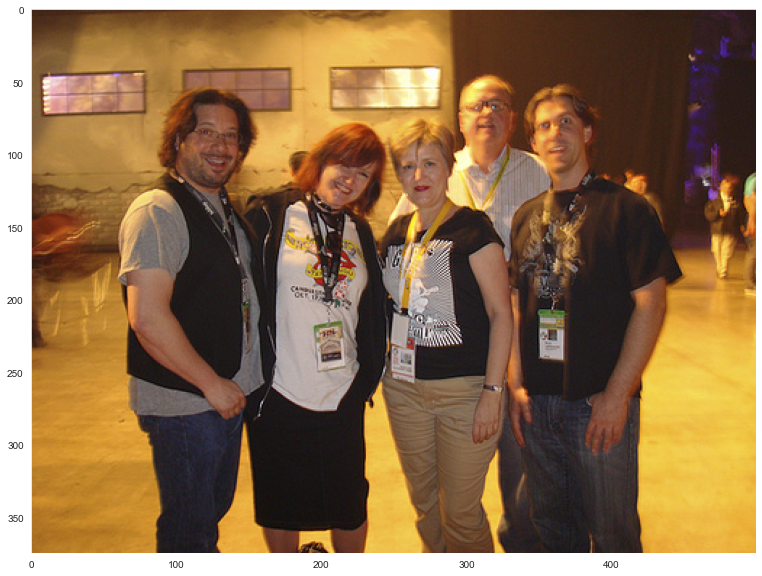

In [79]:
# Test 2

test_model()

BLEU score: 6.361471949532527e-153
Real Caption -> a black and white dog is running towards the viewer
Prediction Caption -> a dog runs through the dry grass


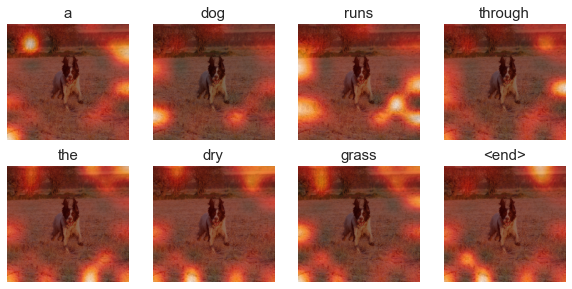

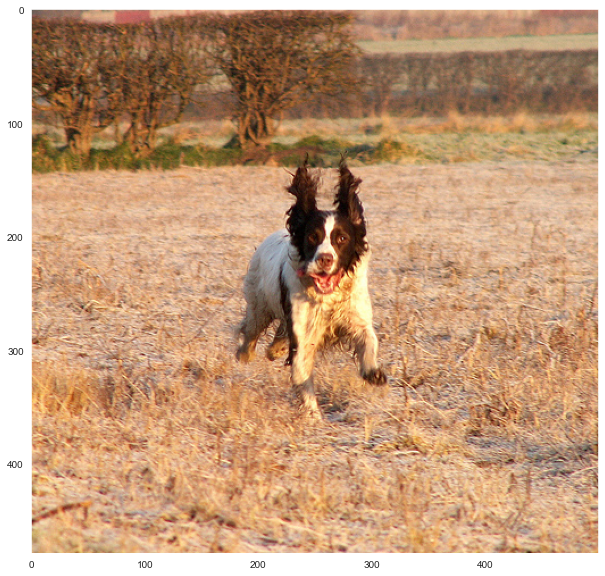

In [80]:
# Test 3

test_model()

BLEU score: 6.581962593704787e-153
Real Caption -> an elderly woman is wearing a pink striped shirt
Prediction Caption -> two woman speaks in blue is standing outdoors


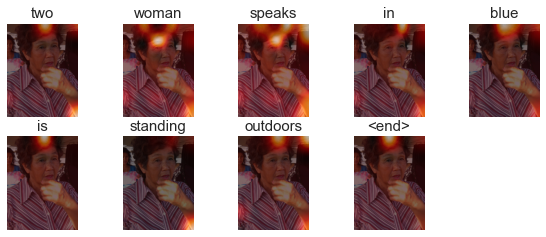

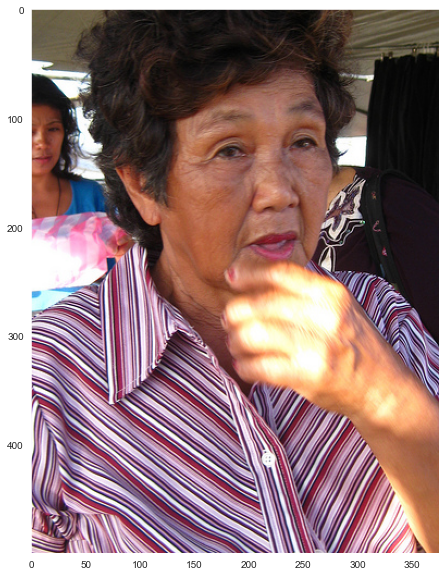

In [81]:
# Test 4

test_model()

BLEU score: 0
Real Caption -> a group of army members aim their guns
Prediction Caption -> cannon wand


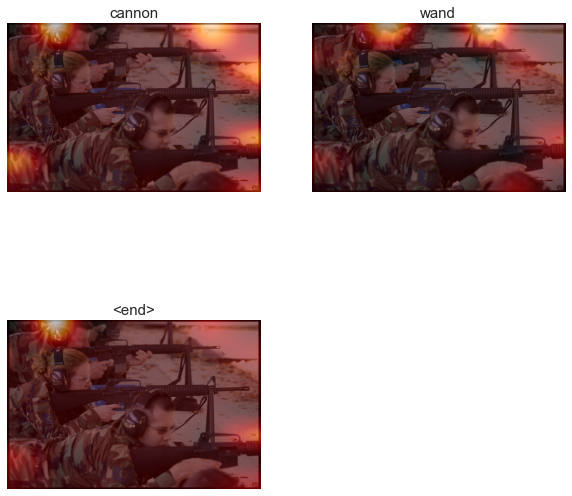

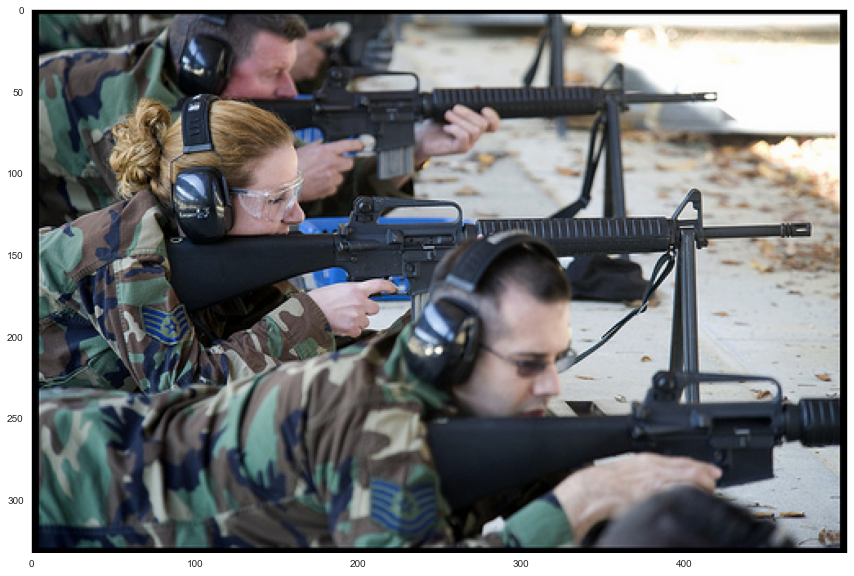

In [82]:
# Test 5

test_model()

## Conclusion

* So we can see that our trained model is able to do image captioning.
* With model subjected to more number of epochs can be able to be more accurate.
* Moreover, augementation in the image can help to increase the accuracy.